In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgbm
from optuna import integration, logging

In [2]:
feat = "feat01"
train = pl.read_csv(f"feat/feat_train_{feat}.csv")
test = pl.read_csv(f"feat/feat_test_{feat}.csv")

cols_exp = [c for c in test.columns if c != "idx"]

### LGBM

In [3]:
def tune_lgbm_params(train, cols_exp, col_target):    
    params = {
        'objective': 'multiclass', 
        'num_class': 3, 
        "metric": "multi_logloss",
        # "force_col_wise": True, 
        "random_seed": 0, 
        'verbose': -1
    }

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # dataset
    train_set = integration.lightgbm.Dataset(x, y)

    # tuning with optuna
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    tuner = integration.lightgbm.LightGBMTunerCV(params=params, 
                                                train_set=train_set, 
                                                num_boost_round=100, 
                                                # num_boost_round=5, 
                                                folds=kf)
    
    logging.set_verbosity(logging.WARNING)
    tuner.run()

    params_tuned = tuner.best_params
    return params_tuned

In [4]:
def train_lgbm(train, cols_exp, col_target, params=None):
    
    if params is None:
        params = {}
        
    params_add = {
        'objective': 'multiclass', 
        'num_class': 3, 
        "n_estimators": 10000, 
        "metric": "multi_logloss",
        # "force_col_wise": True
    }
    params |= params_add

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    y_valid_pred_lst = []
    idx_valid_lst = []
    clf_lst = []

    # cross validation
    for fold, (idx_train, idx_valid) in enumerate(kf.split(x)):
        print("fold", fold)
        x_train = x[idx_train, :]
        x_valid = x[idx_valid, :]
        y_train = y[idx_train]
        y_valid = y[idx_valid]

        # lightgbm modeling
        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train, 
                eval_set=[(x_train, y_train), (x_valid, y_valid)],  
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=50),
                    lgbm.log_evaluation(period=10000),
                ])

        # oof
        y_valid_pred = clf.predict_proba(x_valid)
        y_valid_pred_lst.append(y_valid_pred)
        idx_valid_lst.append(idx_valid)
        clf_lst.append(clf)

    idx_valid = np.hstack(idx_valid_lst)
    y_valid_pred = np.vstack(y_valid_pred_lst)
    oof_pred = y_valid_pred[np.argsort(idx_valid)]

    return clf_lst, oof_pred

In [5]:
def predict_test(x_test, clf_lst):
    y_test_pred_lst = []

    for clf in clf_lst:
        y_test_pred = clf.predict_proba(x_test)
        y_test_pred_lst.append(y_test_pred)

    y_test_pred = np.mean(y_test_pred_lst, axis=0)
    return y_test_pred

In [6]:
col_target = "health"
print("col_target =", col_target, "-"*50)

# parameter tuning with optuna
params_tuned = tune_lgbm_params(train, cols_exp, col_target)

# train LGBM model
clf_lst, oof_pred = train_lgbm(train, cols_exp, col_target, params_tuned)

# predict test with CV ensemble
y_test_pred = predict_test(test[cols_exp].to_numpy(), clf_lst)

# record
oof_pred_df = pl.DataFrame(oof_pred, schema=[f"health_is_{h}" for h in range(3)])
test_pred_df = pl.DataFrame(y_test_pred, schema=[f"health_is_{h}" for h in range(3)])

[I 2024-01-02 23:07:42,553] A new study created in memory with name: no-name-d3645882-7bc7-43f1-9540-823f0769ad40


col_target = health --------------------------------------------------


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

min_child_samples, val_score: 0.600481: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


fold 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.564573	valid_1's multi_logloss: 0.601059
fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.575361	valid_1's multi_logloss: 0.608065
fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's multi_logloss: 0.59652	valid_1's multi_logloss: 0.584082
fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.527584	valid_1's multi_logloss: 0.601724
fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	training's multi_logloss: 0.53951	valid_1's multi_logloss: 0.607429


In [7]:
# save
oof_pred_df.write_csv(f"pred/oof_pred_lgbm_{feat}.csv")
test_pred_df.write_csv(f"pred/test_pred_lgbm_{feat}.csv")

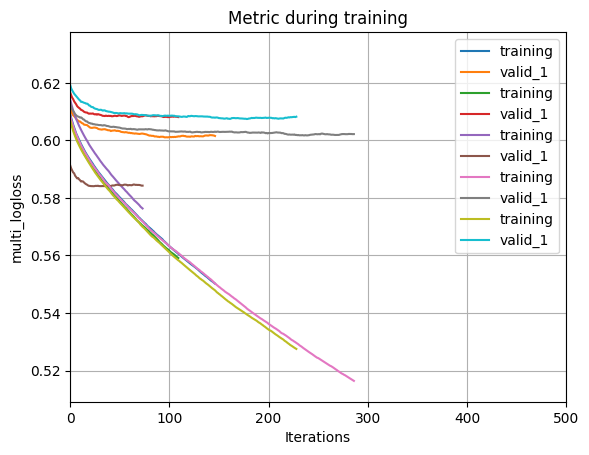

In [8]:
fig, ax = plt.subplots()
for model in clf_lst:
    lgbm.plot_metric(model, ax=ax)
ax.set_xlim(0, 500)
plt.show()
plt.close()